[ 0.03950001+0.05287053j -0.13490598-0.00569407j -0.01612663-0.08723211j
 ...  0.00538247-0.06482302j  0.02647864-0.03472809j
  0.06410099+0.20426802j]
10000


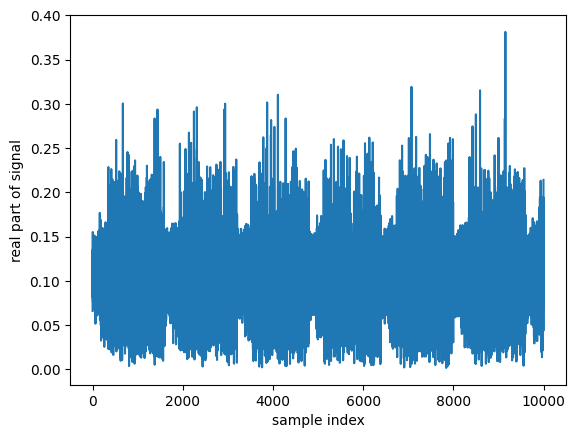

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import file_read

1500


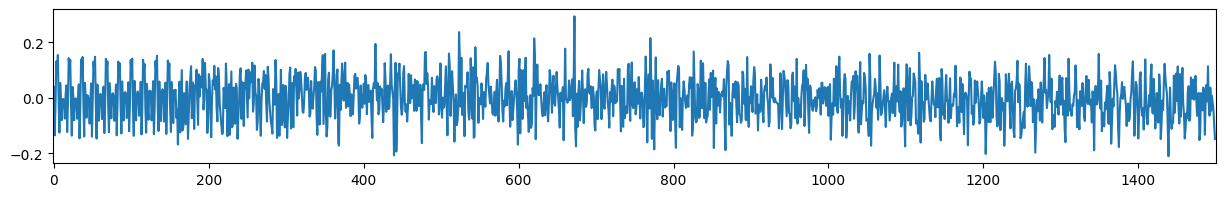

In [23]:
filename = "rx_signal.dat"
count = 0
with open(filename, 'rb') as f:
    count = count+1
    data = np.fromfile(f, dtype=np.float32)


rx_signal = data[:20000:2] + 1j*data[1:20000:2]
rx_signal = rx_signal[:1500]

pilot_sc = 32+np.array([-21,-7,7,21])
payload_sc = 32+np.array(file_read.payload_sc)
freq_pilot = 32+np.array(file_read.freq_pilot)

def plot_signal(signal, marker=None):
    fig, ax1 = plt.subplots(1,1,figsize=(15,2))
    x = np.arange(len(signal))
    ax1.plot(x,signal)
    if marker is not None:
        ax1.bar([marker],[max(signal)], color='red')
    ax1.set_xlim([-1,len(signal)])
    plt.show()
    
print(len(rx_signal))
plot_signal(rx_signal)

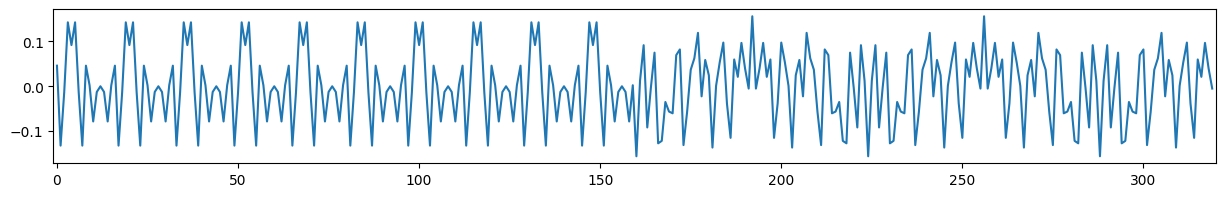

In [24]:
def freq2time(symbol):
    symbol = np.hstack([symbol[32:],symbol[:32]]) # switch indices
    symbol = np.fft.ifft(symbol)
    return np.hstack([symbol[-16:],symbol])

preamble = np.hstack([freq2time(x[:,0]+1j*x[:,1]) for x in np.array(file_read.freq_preamble)])
ltf = preamble[160:320]
plot_signal(preamble.real)

0 0


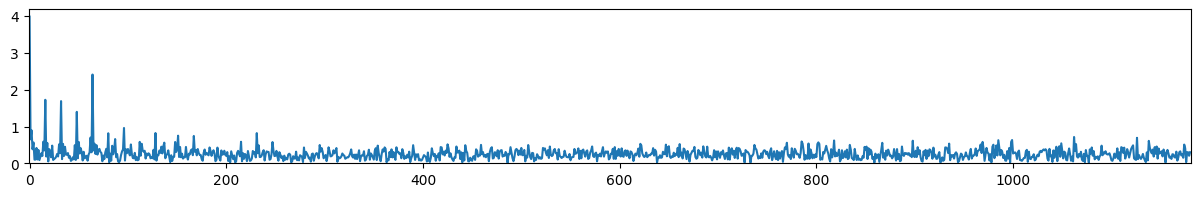

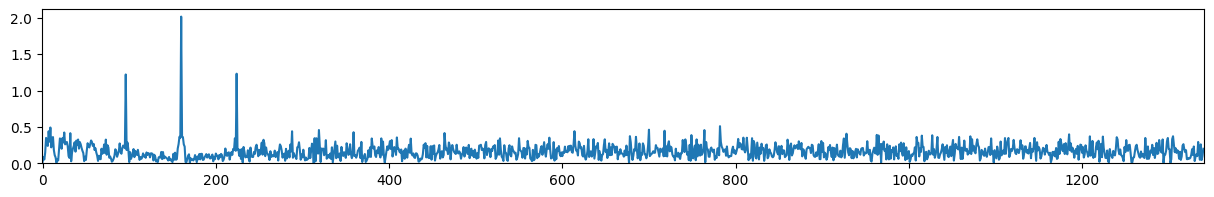

In [25]:
corr1 = np.absolute(np.correlate(rx_signal, preamble))
start1 = np.argmax(corr1)

corr2 = np.absolute(np.correlate(rx_signal, ltf))
start2 = np.argmax(corr2) - 160

print(start1, start2)
plot_signal(corr1, marker=start1)
plot_signal(corr2, marker=start2)

In [26]:
preamble_rec = rx_signal[start1:start1+320]
payload_rec = rx_signal[start1+320:]

In [46]:
def cfo_comp(symbol):
    a, b = symbol[:16], symbol[-16:]
    phi = np.angle((a*b.conj()).sum())
    symbol = symbol[16:]*np.exp(1j*phi*np.arange(64)/64)
    return symbol

def time2freq(symbol):
    symbol = np.fft.fft(symbol)
    symbol = np.hstack([symbol[32:],symbol[:32]]) # switch indices
    return symbol

def channel_est(symbol, pilot, preamble):
    H_est = np.sum(symbol[pilot_sc] / pilot)
    H_est = H_est * np.mean(np.absolute(preamble)) / np.absolute(H_est)
    return H_est

# first symbol for channel estimate
s = payload_rec[:80]
s = time2freq(cfo_comp(s))
H_est = channel_est(s,freq_pilot[0])
    
# ltf for actual channel
ltf_freq = np.array(file_read.freq_preamble[3])
ltf_freq = ltf_freq[:,0] + 1j*ltf_freq[:,1]
ltf_rec = preamble_rec[-80:]
ltf_rec = time2freq(cfo_comp(ltf_rec))
H = ltf_rec[payload_sc] / ltf_freq[payload_sc]

print(H_est)
plot_signal(H.real)
plot_signal(H.imag)

TypeError: channel_est() missing 1 required positional argument: 'preamble'

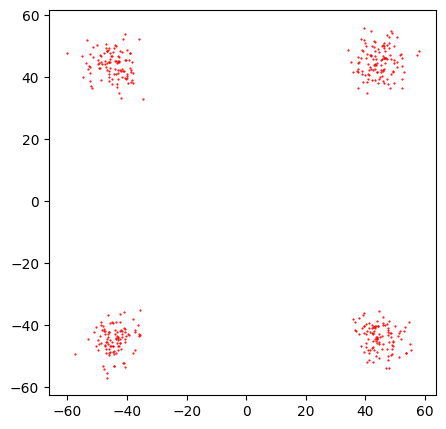

In [45]:
data = []
for i in range(10):
    symbol = payload_rec[80*(i):80*(i+1)]
    symbol = time2freq(cfo_comp(symbol))
    H_est = channel_est(symbol, freq_pilot[i])
    symbol = symbol / H_est
    data.append(symbol[payload_sc])
data = np.hstack(data)

fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(data.real, data.imag, color='red', s=0.3)
plt.show()